## Match Watchability/Excitability Index

- Data from Kaggle for match events for 5 leagues from 2011/12 - current season (Jan 2017).
- Need table standings for each team within their league as of that match.
- For each match, will need to calculate expected win probability to factor into excitement (as per fivethirtyeight)
- Given time, factor in xG (and calculate xG)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import pairwise_distances
from sklearn import cluster

In [2]:
events_df = pd.read_csv('GA/Data/events.csv')

In [3]:
ginf = pd.read_csv('GA/Data/ginf.csv')

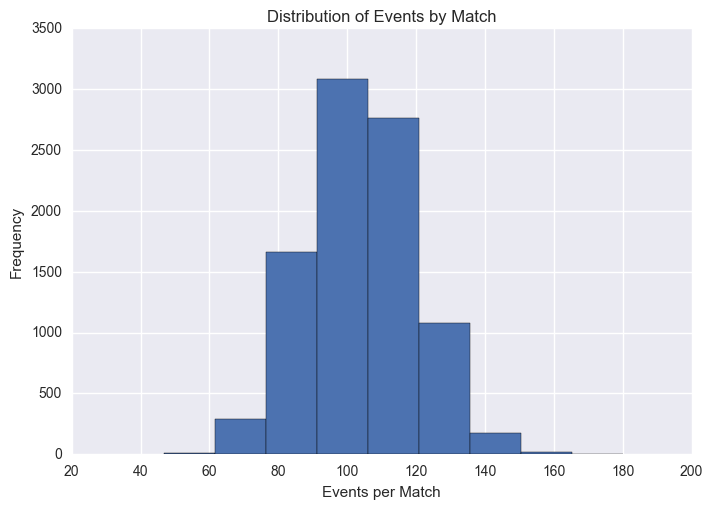

In [40]:
events_df.groupby('id_odsp').id_event.count().plot('hist')
plt.title('Distribution of Events by Match')
plt.xlabel('Events per Match')
plt.show()

In [14]:
## Depending on level of comparison, calculate either across leagues or entire dataset

print events_df.groupby('id_odsp').id_event.count().mean()
print events_df.groupby('id_odsp').id_event.count().median()

## Little difference between mean and median

103.703879215
103.0


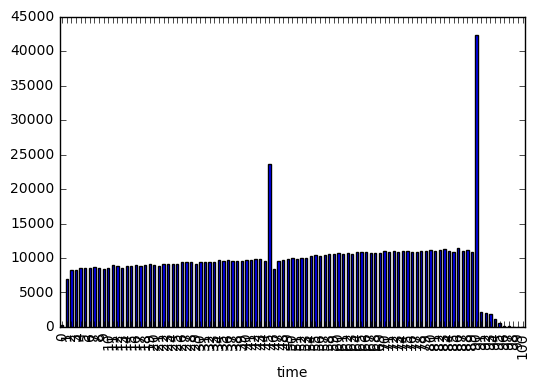

In [15]:
## events by time
## spikes at minutes 45 and 90 (ends of halves)

events_df.groupby('time').id_event.count().plot('bar')
plt.show()

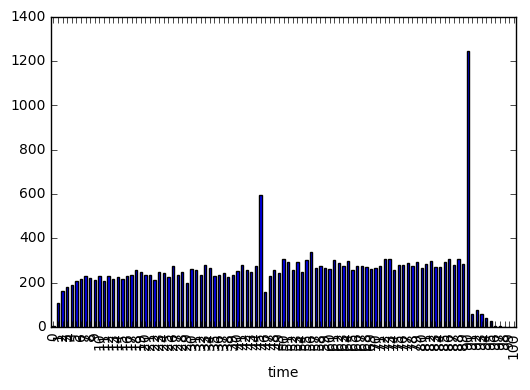

In [16]:
events_df.groupby('time').is_goal.sum().plot('bar')
plt.show()

In [19]:
## For loop to assign current home goals at that point in a given match
## Function w apply not working... going to use loop

goals = 0
events_df['prev_id'] = events_df.id_odsp.shift()
for i, row in events_df.iterrows():
    if row.id_odsp != row.prev_id:
        goals = 0
    if (row.is_goal == 1) and (row.side == 1):
        goals += 1
    events_df.loc[i, 'home_goals'] = goals

In [27]:
## away goals

goals = 0
events_df['prev_id'] = events_df.id_odsp.shift()
for i, row in events_df.iterrows():
    if row.id_odsp != row.prev_id:
        goals = 0
    if (row.is_goal == 1) and (row.side == 2):
        goals += 1
    events_df.loc[i, 'away_goals'] = goals

In [31]:
## Data is saved in csv - no more for loops!

#events_df.to_csv('soccer_events.csv', encoding='utf-8')

## Calculating the average goal difference throughout a match.

The steps below calculate the average goal difference at each minute of a match to measure how close a given match is. First, I create a new column in the existing dataframe to determine the goal difference at that point in the match. I create a separate dataframe that shows the goal difference at each minute for each match, and then write a function to fill in all minutes for a match in which no events occurred using the preceding goal difference. The average of all values across the entire match is then calculated.

In [ ]:
## Dataframe was previously saved - read in data
df = pd.read_csv('soccer_events.csv')

In [ ]:
df['score_diff'] = abs(df.home_goals - df.away_goals)

## Pivot on score_diff for each game at each point in time
## aggfunc is 'last' to take last occurring difference - i.e., if two goals scored in same minute, take last event
time_diff = df.pivot_table(values = 'score_diff', index = 'id_odsp', columns = 'time', aggfunc = 'last')

## clean up column names a little bit to indicate minutes
time_diff.columns = [str(col) + '_min' for col in time_diff.columns]

## if no events in 0th minute, fill goal difference as 0
time_diff['0_min'].fillna(0, inplace = True)

## for minutes with no events in a match, fill with previous minutes' difference
## ffill each row up until last listed event

def fill_row(match):
    match = match.copy()
    non_nans = match[~match.apply(np.isnan)]
    start, end = non_nans.index[0], non_nans.index[-1]
    match.ix[start:end] = match.ix[start:end].fillna(method='ffill')
    return match

time_diff = time_diff.apply(fill_row, axis = 1)

## Fill up to 90th minute if no events

time_diff.ix[:,'78_min':'90_min'].ffill(axis = 1, inplace = True)

## avg goal differential in match
avg_time_diff = time_diff.transpose().mean().reset_index()
avg_time_diff.columns = [['id_odsp','avg_goal_diff']]
avg_time_diff.head()

The steps below calculate the total number of lead changes by match to indicate a higher amount of scoring, and also more excitement.

In [ ]:
for i, row in goal_df.iterrows():
    if row.home_goals > row.away_goals:
        leader = 'home'
    if row.away_goals > row.home_goals:
        leader = 'away'
    if row.home_goals == row.away_goals:
        leader = 'tied'
    goal_df.loc[i, 'leader'] = leader

goal_df['prev_leader'] = goal_df.groupby('id_odsp').leader.shift().fillna('tied')

## Another for loop to flag if score is lead change

for i, row in goal_df.iterrows():
    if row.id_odsp == row.prev_id:
        if row.leader != row.prev_leader:
            ld_chg = 1
        else: 
            ld_chg = 0
        goal_df.loc[i, 'lead_change'] = ld_chg

## Total lead changes by match
goal_df.groupby('id_odsp').lead_change.sum().sort_values().reset_index()

Now that all fields have been calculated, the steps below will join to the original dataframe with individual match data.

In [ ]:
## Adding lead changes into overall match data
match_df = pd.merge(ginf, goal_df.groupby('id_odsp').lead_change.sum().reset_index(), on = 'id_odsp', how = 'left')
## Will need to fillna for new column w 0 value to indicate no lead changes
match_df.lead_change.fillna(0, inplace = True)

## Match events
match_df = pd.merge(match_df, df.groupby('id_odsp').id_event.count().reset_index(), on = 'id_odsp', how = 'inner')

## Average goal differential
match_df = pd.merge(match_df, avg_time_diff, on = 'id_odsp', how = 'inner')

The next step is to use unsupervised clustering to create groups of matches according to the metrics calculated above.

In [ ]:
X = match_df[['lead_change','id_event','avg_goal_diff']]

sns.pairplot(X)
plt.show()

In [ ]:
X_scaled = preprocessing.StandardScaler().fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)

k = 4
kmeans = cluster.KMeans(n_clusters=k, random_state = 43)
kmeans.fit(X_scaled)

labels = kmeans.labels_
centroids = kmeans.cluster_centers_
inertia = kmeans.inertia_

print labels
print centroids
print inertia

print metrics.silhouette_score(X_scaled, labels, metric='euclidean')

match_df['cluster'] = labels



In [ ]:
X['cluster'] = labels
cols = X.columns[:-1]
sns.pairplot(X, x_vars=cols, y_vars= cols, hue='cluster')
plt.show()

In [ ]:
match_df.drop([u'odd_h', u'odd_d',u'odd_a', u'odd_over', u'odd_under', u'odd_bts', u'odd_bts_n'], axis = 1, inplace = True)

match_df['date'] = pd.to_datetime(match_df['date'])
match_df['month'] = match_df.date.apply(lambda x: x.month)
match_df['year'] = match_df.date.apply(lambda x: x.year)

centroid_df = pd.DataFrame(centroids, columns = X_scaled_df.columns)
centroid_df

- Cluster 0 - Second Fewest Lead Changes (rank 3), Second Fewest Events(rank 3), Largest average goal differential (rank 4)
- Cluster 1 - Most Lead Changes (rank 1), Second Most Events (rank 2), Second largest avg goal diff (rank 3)
- Cluster 2 - Second most lead changes (rank 2), most events (rank 1), third largest avg goal diff (rank 2)
- Cluster 3 - fewest lead chanegs (rank 4), fewest events (rank 4), smallest avg goal diff (rank 1)

### Save match df with clusters and engineered features
```python
match_df.to_csv('match_cluster.csv', encoding='utf-8')
```

In [ ]:
match_df = pd.read_csv('match_cluster.csv')

match_df = match_df.drop(['Unnamed: 0','link_odsp','adv_stats'], axis = 1)

england = match_df[match_df.country == 'england']
spain = match_df[match_df.country == 'spain']
germany = match_df[match_df.country == 'germany']
france = match_df[match_df.country == 'france']
italy = match_df[match_df.country == 'italy']